# Speed control in biological sequence-generating network

Conductance-based LIF network. Single-neuron voltage dynamics:

$$C_m \frac{dV}{dt} = g_l[E_l - V(t)] + g_e(t)[E_e - V(t)] + g_i(t)[E_i - V(t)] + I_{ext}(t)$$

The time-varying conductances $g_e(t)$ and $g_i(t)$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$, respectively (convention: weight to $i$ from $j$):

$$\tau_e\frac{dg^i_e}{dt} = -g^i_e + \sum_j W_e^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + \sum_j W_i^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

where $t_k^j$ are the spike times in the $j$-th neuron.


Inhibitory conductance assumption:

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + N_{i} W_{i-e} r_{i} \tau_i\ + g_{UVA} $$

$$ g^i_i(t) = A^i e^{-t/\tau_i} + C^i $$

$$ g^i_i = N_{i} W_{i-e} r_{i} \tau_i\ + g_{UVA} $$
$$ t' $$

$$ \lim_{\xi \to 0} g(t' + \xi) - g(t' - \xi) = W_{ff}$$

$$C_m \frac{dV}{dt} = g_l[E_l - V(t)] + g_e(1-e^{-\frac{t}{\tau}})[E_e - V(t)] + (N_{i} W_{i-e} r_{i} \tau_i\ + g_{UVA})[E_i - V(t)] + I_{ext}(t)$$

## Parameters

All param values are in SI units, with capacitance and conductance per cm$^2$.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
import pickle
import datetime
import os

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w

from utils.general import *
from utils.file_io import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=1.6e-3,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, T_E=.002, T_I=.002,

    # NTWK ARCHITECTURE
    N_L=40,  # num chain links
    N_L_E=30,  # num E nrns per chain link
    W_E_E_R=0.005e-3,  # E-E recurrent cxns w/in chain link
    W_E_E_F=0.01e-3,  # E-E feed-forward from one link to next
    W_U_E_I=0.05e-3,  # I->E input weights
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s)) 
    I_EXT_B=0,  # additional baseline current input
)

# Sifting through results of the parameter search
Here's some code to load batches of experiments

### Helper functions

In [18]:
def spk_tms_for_link(spks_t, spks_c, idx, n_l_e):
    link_start_idx = idx * n_l_e
    window = (spks_c >= link_start_idx) & (spks_c < (link_start_idx + n_l_e))
    return spks_t[window]

def tms_for_link(spks_t, spks_c, n_l, n_l_e):
    return [spk_tms_for_link(spks_t, spks_c, i, n_l_e) for i in range(n_l)]

def last_spk_tm(tms_p_link):
    l = len(tms_p_link)
    for i in range(l):
        tms_for_link = tms_p_link[l - i - 1]
        if len(tms_for_link) > 0:
            return tms_for_link[-1]

Define functions for loading and scanning experiments for interesting results by batch

In [133]:
def load_batches(batch_path):
    fs = [f for f in sorted(all_files_with_name_frags(batch_path, 'batch_'))]
    for f_idx, f in enumerate(fs):
        batch_data = pickle.load(open(os.path.join(batch_path, f), 'rb'))
        yield batch_data
        
slp_ratio_thrsh = 1.92

def process_single_exp(experiment_results, m):
    x = np.arange(m.N_L) + 1
    results = []
    
    keep = True
    first_inv_slope = None
    inv_slp_ratio = None

    for frq_idx, frq_res in enumerate(experiment_results):

        tms_p_link = tms_for_link(frq_res['spks_t'], frq_res['spks_c'], m.N_L, m.N_L_E)
        mean_tms_p_link = np.array([np.mean(tms_for_link) for tms_for_link in tms_p_link])
        std_tms_p_link = np.array([np.std(tms_for_link) for tms_for_link in tms_p_link])

        mean_of_std = np.mean(std_tms_p_link[~np.isnan(std_tms_p_link)])
        std_of_std = np.std(std_tms_p_link[~np.isnan(std_tms_p_link)])

        counts_per_link = np.array(map_to_list(lambda l: l.size, tms_p_link))
        mean_cnts_p_link = np.mean(counts_per_link[counts_per_link > 0])
        std_cnts_p_link = np.std(counts_per_link[counts_per_link > 0])

        if ((len(tms_p_link[-1]) == 0 and (last_spk_tm(tms_p_link) < (.3 - 0.01)))
            or std_of_std / mean_of_std > 0.3
            or std_cnts_p_link / mean_cnts_p_link > 0.3
            or mean_cnts_p_link > 6 * m.N_L_E
            or mean_cnts_p_link < 2.7 * m.N_L_E):
            keep = False
            break

        slp, icpt = stats.linregress(x, mean_tms_p_link)[:2]
        if frq_idx == 0:
            first_inv_slope = 1./slp
        elif frq_idx == 2:
            if first_inv_slope is None:
                keep = False
                break
            inv_slp_ratio = first_inv_slope / (1./slp)
            if np.isnan(inv_slp_ratio) or inv_slp_ratio < slp_ratio_thrsh:
                keep = False
                break
        results.append([mean_tms_p_link, std_tms_p_link, slp, icpt, tms_p_link])
    if keep:
        return (results, inv_slp_ratio)

def parse_param_results(all_results_for_params, m):
    if type(all_results_for_params[0]) is list:
        l = len(all_results_for_params)
        processed = [process_single_exp(res, m) for res in all_results_for_params]
        for el in processed:
            if el is None:
                return None
        return processed
    else:
        processed = process_single_exp(all_results_for_params, m)
        if processed is not None:
            return [processed]
        
def scan_batch(batch_results, batch_params, m, batch_idx):
    x = np.arange(m.N_L) + 1
    passing_scan = []

    for r in zip(batch_results, batch_params):
        (all_results_for_params, params) = r
        processed = parse_param_results(all_results_for_params, m)
        if processed is not None:
            passing_scan.append((params, processed))

    for idx, (params, processed) in enumerate(passing_scan):
        print(params)
        inv_slope_rs = [inv_slope_r for res, inv_slope_r in processed]
        print(np.mean(inv_slope_rs))
        print(np.std(inv_slope_rs))
        
        for frq_idx, frq_res in enumerate(processed[0][0]):
            (mean_tms_p_link, std_tms_p_link, slp, icpt, tms_p_link) = frq_res
            gs = gridspec.GridSpec(2, 1)
            fig = plt.figure(figsize=(10, 10), tight_layout=True)
            axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
            axs[0].set_title(f'index: {batch_idx}{idx} freq: {frq_idx * 400} params:' + ' '.join(map_to_list(lambda p_i: f'{p_i}', params)))
            axs[0].fill_between(x, mean_tms_p_link - std_tms_p_link, mean_tms_p_link + std_tms_p_link, color='red', alpha=0.25)
            axs[0].scatter(x, mean_tms_p_link, s=3, c='red')
            axs[0].set_ylim(0, 0.3)
            axs[0].set_xlim(0, m.N_L)

            for l_cntr in range(m.N_L):
                y = l_cntr * np.ones(len(tms_p_link[l_cntr])) + 1
                axs[1].scatter(tms_p_link[l_cntr], y + .2 * np.random.randn(len(y)), s=5, c='black', zorder=0)
                axs[1].set_ylim(0, m.N_L)
        print('')
    return passing_scan


[1.500e-06 1.650e-06 5.250e-06 8.650e-06 3.375e-01 4.500e-01 1.025e-01]
1.9711294752218345
0.014487238361045148

[1.500e-06 1.650e-06 5.250e-06 8.650e-06 3.375e-01 4.500e-01 1.050e-01]
1.9380916268341402
0.0046851218848043665

[1.50e-06 1.70e-06 5.50e-06 8.80e-06 3.50e-01 4.50e-01 1.05e-01]
1.962682422474817
0.03534885160692169



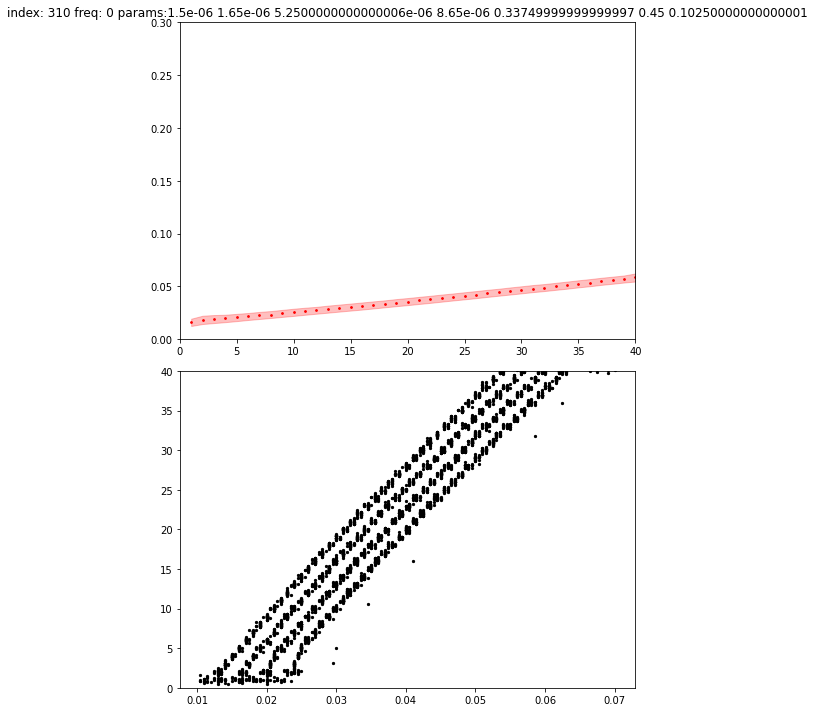

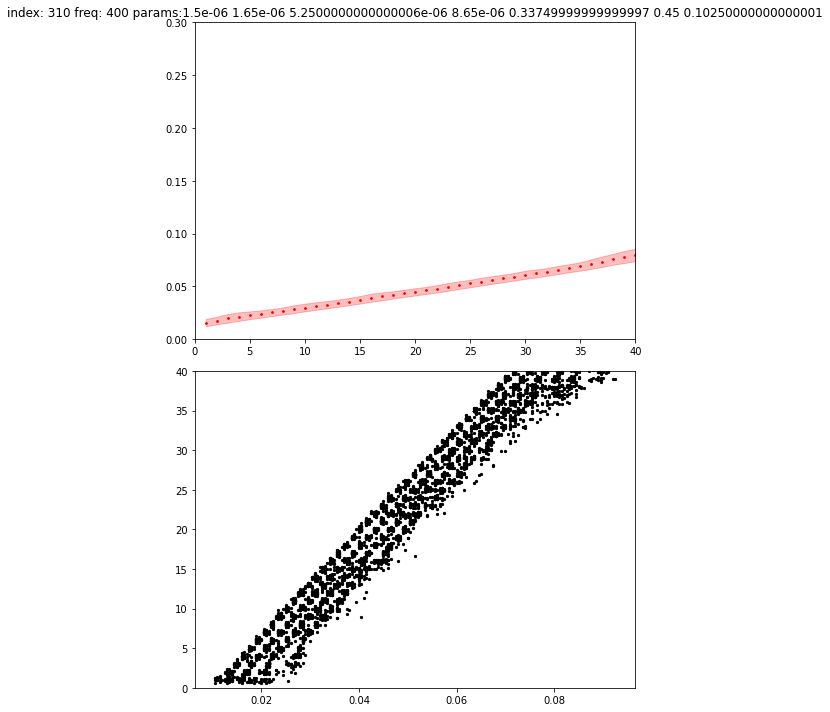

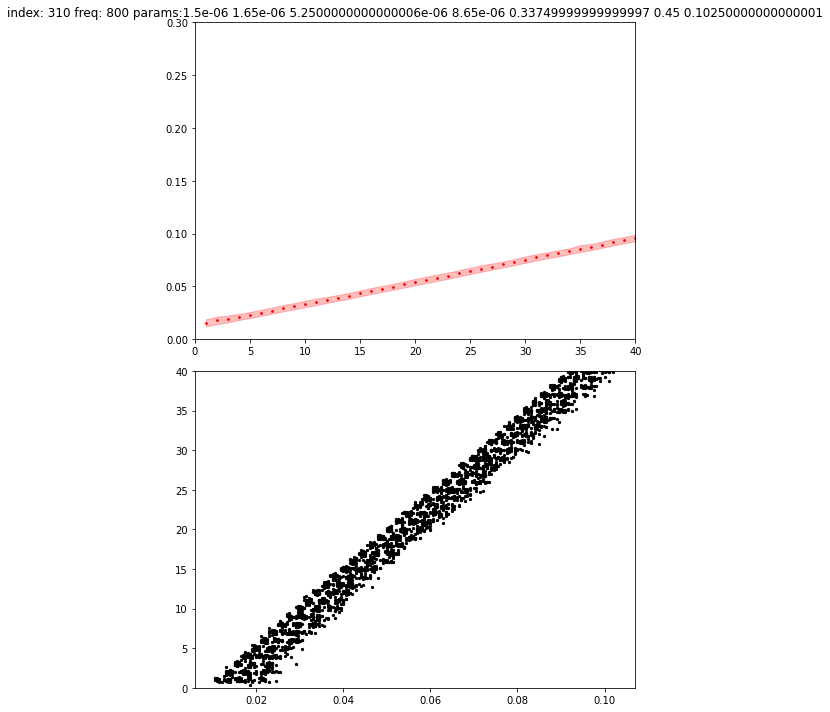

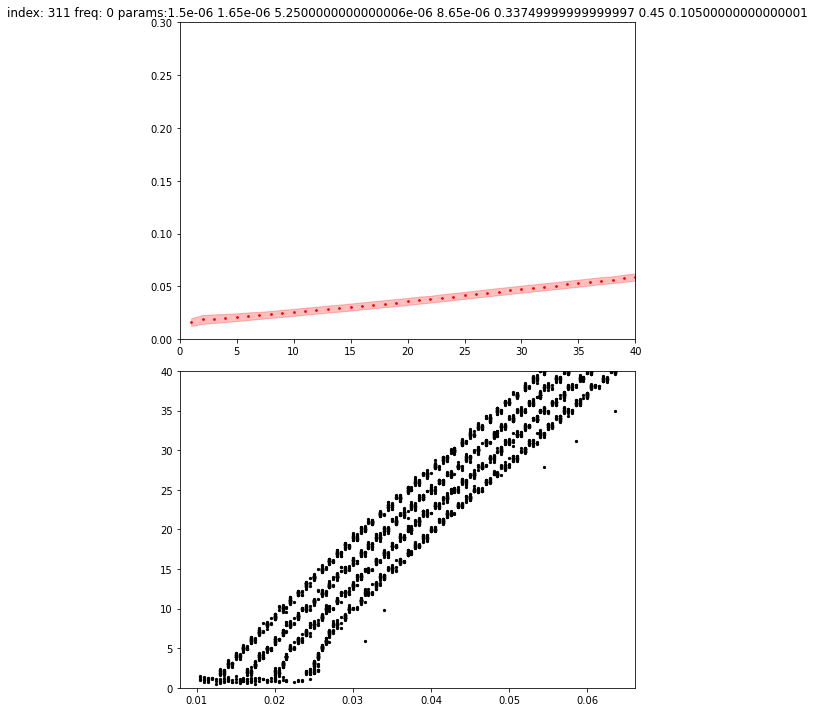

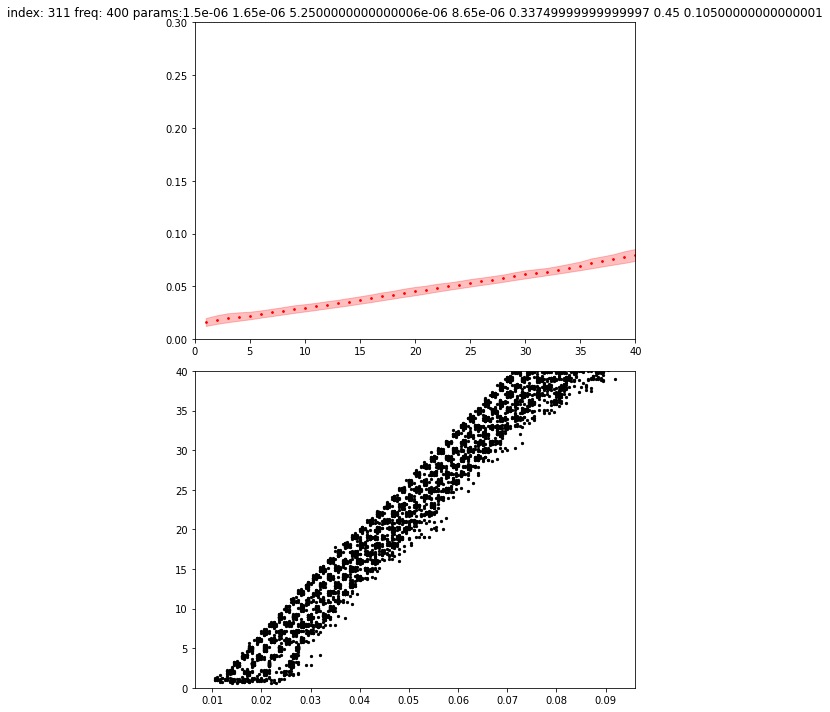

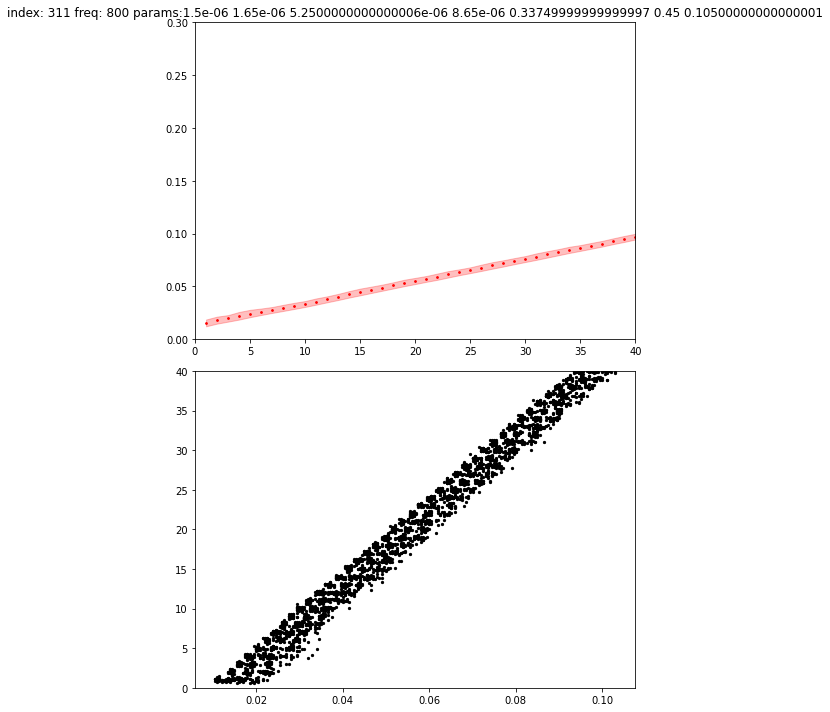

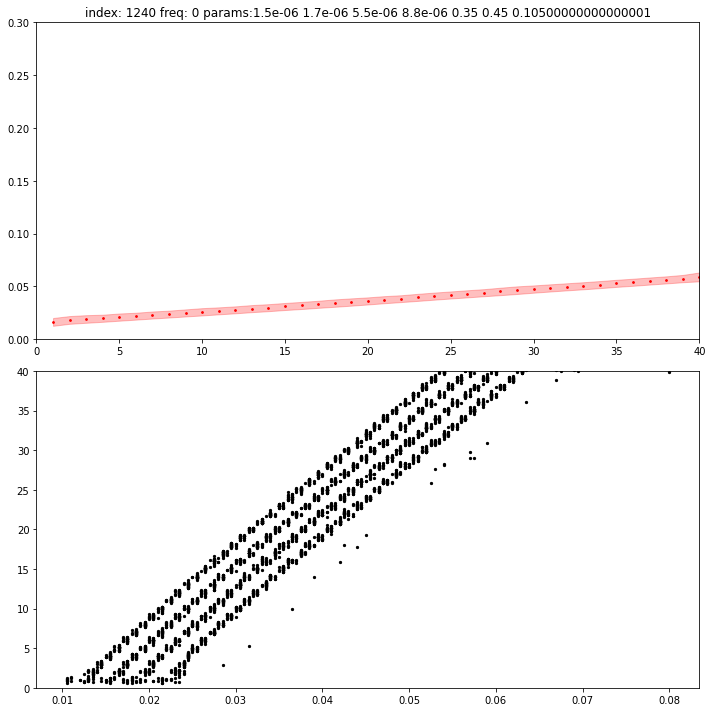

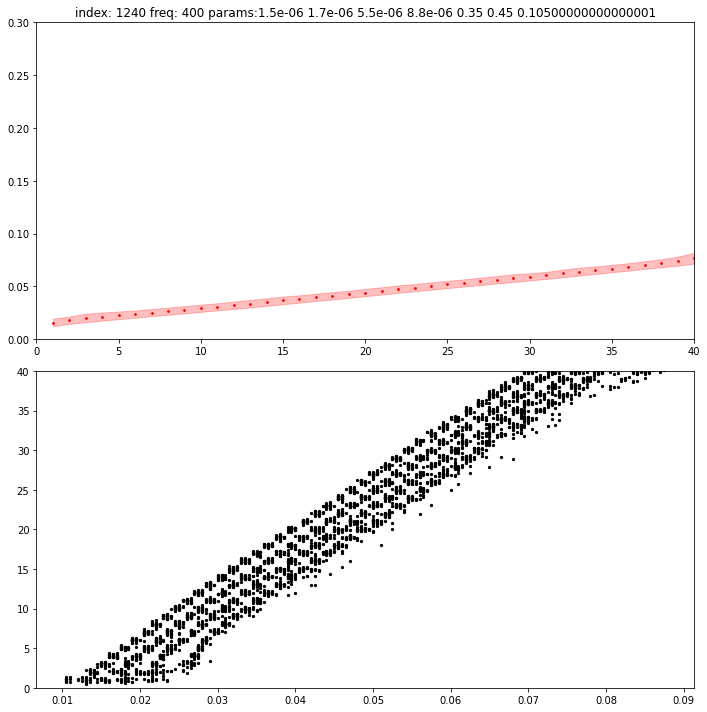

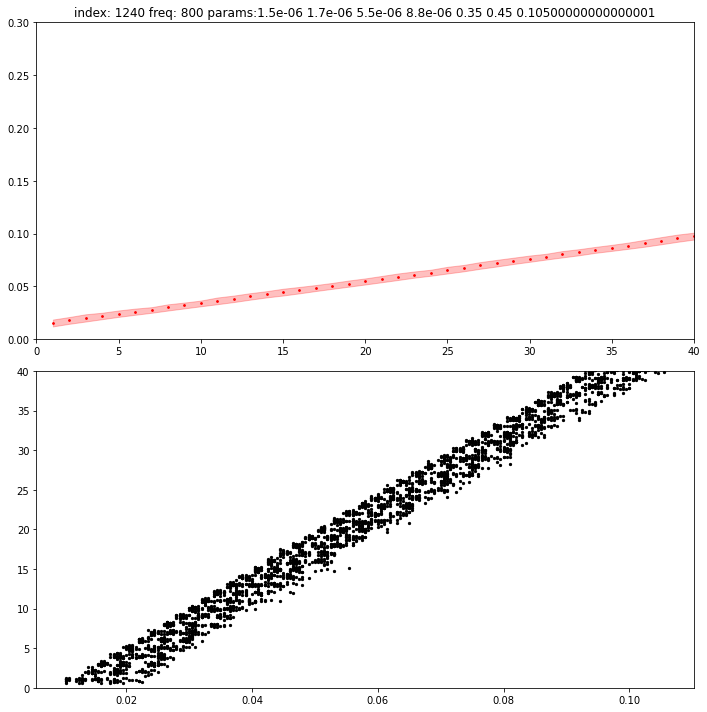

In [139]:
params = pickle.load(open(os.path.join(batch_path, 'params.p'), 'rb'))
config = pickle.load(open(os.path.join(batch_path, 'config.p'), 'rb'))

results_meeting_criteria = []

batch_path = './data/exp_2020-06-17--11:10'

for batch_idx, batch_data in enumerate(load_batch(batch_path)):
    batch_start = batch_idx * config['batch_size']
    batch_end = np.min([batch_start + config['batch_size'], len(params)])
    results_meeting_criteria.append(scan_batch(batch_data, params[batch_start:batch_end], M, batch_idx))